# What are LSTMS
LSTMs are an extension of recurrent neural networks (RNNS). They are designed to remember a history of previous inputs rather than solely the prior input as in RNNs. Hence, we can think of LSTMs holding "short-term memory". LSTMs are thus well-suited for tasks where the seqeuence of inputs matters (i.e. NLP and time-series analysis). RNNs suffer from the vanishing gradeint problem, meaning gradients during backpropogation become smaller and smaller as they propogate through the layers, yielding negligible updates in parameters (no learning).

# Challenges with Traditional Models
Traditional models like ARIMA and linear regressions rely on assumptions such as constant variance over time. However, in the real world, these assumptions often do not hold true for a variety of factors. Moving averages are also popular, but struggle to consider data beyond the scope of their window.

# LSTM Architecture
LSTMs are made up of memory cells, These cells contain gates that control the flow of information though the network.

*   Forget Gate: Decides what information to forget from the previous cell state.
*   Input Gate: Determines what new information to store in the current cell state.
*   Output Gate: Controls what information from the current cell state to output.

Basically, the different gates serve to select what information we can forget, and what is worth remembering.






# Dataset - Google Stock Prices

In [48]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Alphabet Inc. (Google)
ticker = 'GOOGL'

# Fetch daily historical data from 2016-01-01 to today's date
start_date = '2016-01-01'
end_date = '2024-10-13'  # Adjust the end date to the current date

# Download the data
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Display the first few rows of the data
data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.878208,67382000
2016-01-05,38.205002,38.459999,37.782501,38.076500,37.982449,45216000
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.872719,48206000
2016-01-07,37.324501,37.765499,36.764000,37.049999,36.958485,63132000
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.455235,47506000


We will focus on predicting close prices. We will include volume as an additional feature.

In [49]:
close_data = data[['Close', 'Volume']]
close_data.head()

,Close,Volume
Date,,
2016-01-04,37.972000,67382000
2016-01-05,38.076500,45216000
2016-01-06,37.966499,48206000
2016-01-07,37.049999,63132000
2016-01-08,36.545502,47506000


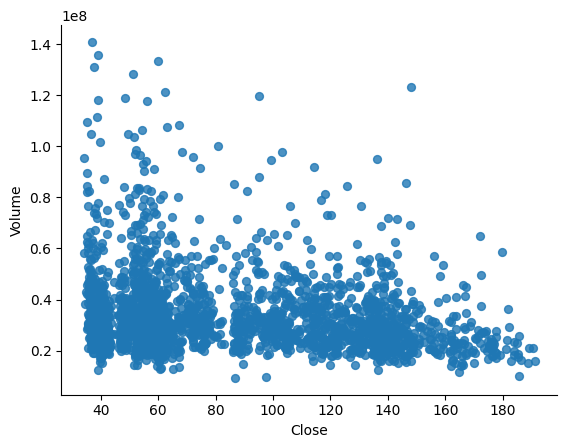

In [50]:
from matplotlib import pyplot as plt
close_data.plot(kind='scatter', x='Close', y='Volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Visualize the Data

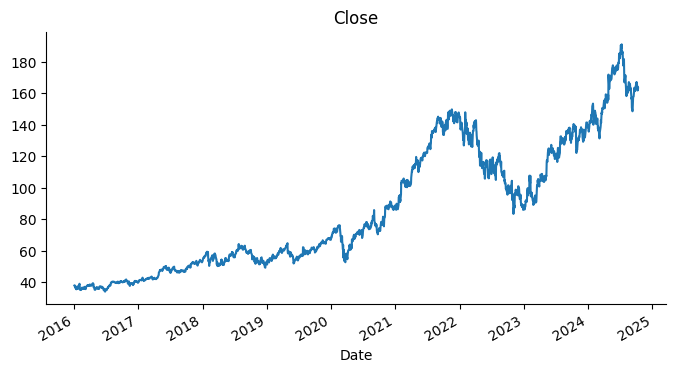

In [51]:
from matplotlib import pyplot as plt
close_data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

# Data Pre-processing

In [52]:
from sklearn.preprocessing import MinMaxScaler

# split the training and test data
training_size = round(len(close_data) * 0.80)
train_data = close_data[:training_size]
test_data  = close_data[training_size:]

# scale train_data
min_max_scaler = MinMaxScaler()
train_data_scaled = min_max_scaler.fit_transform(train_data[['Close', 'Volume']])

# scale test_data using the same scaler fitted on the training data
test_data_scaled = min_max_scaler.transform(test_data[['Close', 'Volume']])


In [53]:
import numpy as np

def x_y_split(data, window):
    # Convert the data to a NumPy array
    data_values = data[:, :]  # Input data (Close, Volume) - assuming already scaled
    close_values = data[:, 0] # Output data (just Close)

    # Create empty lists to hold the input (X) and output (y) data
    X, y = [], []

    # Loop through the dataset to create sequences of `window` length
    for i in range(len(data) - window):
        # Input sequence (X) is the data from current index to current index + window
        X.append(data_values[i:i + window])
        # Output (y) is the value right after the input sequence
        y.append(close_values[i + window])

    # Convert the lists into NumPy arrays
    X, y = np.array(X), np.array(y)

    return X, y


In [54]:
window = 50
X_train, y_train = x_y_split(train_data_scaled, window)
X_test, y_test = x_y_split(test_data_scaled, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# 1717 observations in training of window size 50

(1717, 50, 2) (1717,) (392, 50, 2) (392,)


# Model

Two layers, with dropout in between for regularization. Window size is 50. Loss function is MSE. Dropout is 10%. MSE is the loss function and MAE is the error mertic. MSE is well-suited for the loss function because it is good for gradient based optimization and reducing error. MAE is a good error metric because it is interpretible and is intuitive across all predictions. Dropout randomly deactivates a set of neurons to avoid overfitting and improve regularization.

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))

model.add(LSTM(units=50))
model.add(Dropout(0.1))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [56]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0497 - mean_absolute_error: 0.1369 - val_loss: 0.0051 - val_mean_absolute_error: 0.0578
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0022 - mean_absolute_error: 0.0330 - val_loss: 0.0055 - val_mean_absolute_error: 0.0615
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0019 - mean_absolute_error: 0.0293 - val_loss: 0.0023 - val_mean_absolute_error: 0.0382
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0017 - mean_absolute_error: 0.0281 - val_loss: 0.0075 - val_mean_absolute_error: 0.0746
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0015 - mean_absolute_error: 0.0260 - val_loss: 0.0036 - val_mean_absolute_error: 0.0487
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0017 - mean_absolute_error: 0.0275 - val_loss: 0.0023 - val_mean_absolute_error: 0.0372
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0015 - mean_absolute_error: 0.0260 - val_loss

In [57]:
# Predict the 'Close' price (1 feature) using the test data
test_predicted = model.predict(X_test)

# Create an array of zeros with the same shape as test_predicted for the 'Volume' column
dummy_volume = np.zeros((test_predicted.shape[0], 1))

# Concatenate the predicted 'Close' price with the dummy 'Volume' column
test_predicted_with_dummy = np.concatenate((test_predicted, dummy_volume), axis=1)

# Now apply inverse_transform using the MinMaxScaler fitted on the training data
test_inverse_predicted = min_max_scaler.inverse_transform(test_predicted_with_dummy)

# Extract only the 'Close' price (first column) after inverse transformation
test_inverse_predicted = test_inverse_predicted[:, 0]



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Compare the predicitons to the actual prices

In [58]:
# Make a copy of the original test_data
test_data_with_predictions = test_data.copy()

# Add the predicted 'Close' prices as a new column to the copied DataFrame
# We skip the first `window` rows in both the original and predicted data
test_data_with_predictions = test_data_with_predictions.iloc[window:]
test_data_with_predictions['Predicted Close Price'] = test_inverse_predicted

# Display the new DataFrame with the original test data and the predicted prices
test_data_with_predictions.head()

,Close,Volume,Predicted Close Price
Date,,,
2023-03-23,105.599998,40797800,98.355843
2023-03-24,105.440002,30393300,99.886207
2023-03-27,102.459999,31120900,101.368249
2023-03-28,101.029999,32057900,102.425320
2023-03-29,101.389999,28779600,103.005759


<Axes: xlabel='Date'>

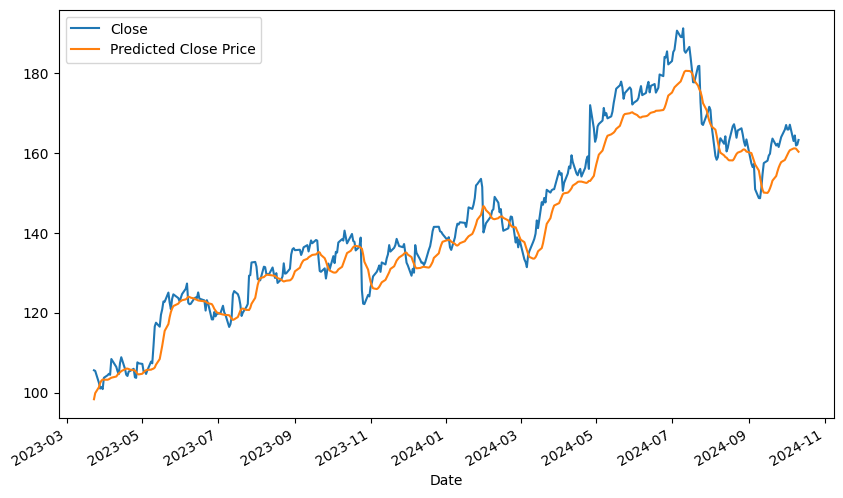

In [59]:
test_data_with_predictions[['Close','Predicted Close Price']].plot(figsize=(10,6))

**error metrics**

R^2 is not as useful here because it is better suited for independent predicitons, not time-series. Time series data often has temporal dependencies, meaning that values at one time step are highly correlated with previous values (e.g., stock prices on consecutive days). This makes it tricky for R² to properly assess a model's performance, as it's designed for independent observations, not sequentially dependent data.

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_data_with_predictions['Close'].values  # Actual 'Close' prices
y_pred = test_data_with_predictions['Predicted Close Price'].values  # Predicted 'Close' prices

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 4.271838284023904
Mean Squared Error (MSE): 27.90174157584719
Root Mean Squared Error (RMSE): 5.282209914027195


In [61]:
pre_2024_05_predictions = test_data_with_predictions.loc[:'2024-05-01']

<Axes: xlabel='Date'>

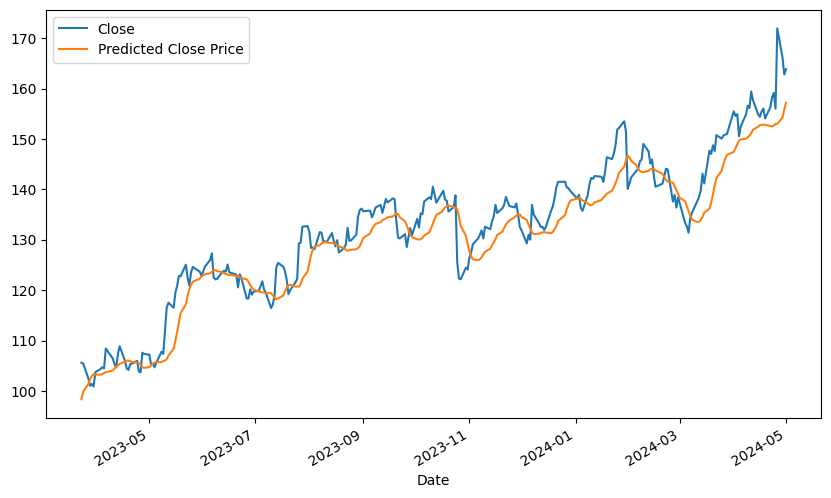

In [62]:
pre_2024_05_predictions[['Close','Predicted Close Price']].plot(figsize=(10,6))

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = pre_2024_05_predictions['Close'].values  # Actual 'Close' prices
y_pred = pre_2024_05_predictions['Predicted Close Price'].values  # Predicted 'Close' prices

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 3.641327748811106
Mean Squared Error (MSE): 21.79017916748397
Root Mean Squared Error (RMSE): 4.667995197885702


**Now let's consider if the close prices of similar companies (FAANG) companies were used as training features**

In [64]:
faang_companies = ['AAPL', 'AMZN', 'META', 'NFLX']
company_close_data = close_data.copy()

for company in faang_companies:
  company_data = yf.download(company, start=start_date, end=end_date, interval='1d')
  company_close_data[company] = company_data['Close']

company_close_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Close,Volume,AAPL,AMZN,META,NFLX
Date,,,,,,
2016-01-04,37.972000,67382000,26.337500,31.849501,102.220001,109.959999
2016-01-05,38.076500,45216000,25.677500,31.689501,102.730003,107.660004
2016-01-06,37.966499,48206000,25.174999,31.632500,102.970001,117.680000
2016-01-07,37.049999,63132000,24.112499,30.396999,97.919998,114.559998
2016-01-08,36.545502,47506000,24.240000,30.352501,97.330002,111.389999


In [65]:
company_close_data.corr()

,Close,Volume,AAPL,AMZN,META,NFLX
Close,1.000000,-0.207659,0.959806,0.882161,0.848530,0.780510
Volume,-0.207659,1.000000,-0.183154,-0.176249,-0.218856,-0.155983
AAPL,0.959806,-0.183154,1.000000,0.853329,0.768566,0.724181
AMZN,0.882161,-0.176249,0.853329,1.000000,0.838759,0.922326
META,0.848530,-0.218856,0.768566,0.838759,1.000000,0.870245
NFLX,0.780510,-0.155983,0.724181,0.922326,0.870245,1.000000


All of the FAANG comapnies seem to have highly correlated stocks

In [66]:
# split the training and test data
training_size = round(len(close_data) * 0.80)
train_data = company_close_data[:training_size]
test_data  = company_close_data[training_size:]

# scale train_data
min_max_scaler = MinMaxScaler()
train_data_scaled = min_max_scaler.fit_transform(train_data[['Close', 'Volume','AAPL', 'AMZN', 'META', 'NFLX']])

# scale test_data using the same scaler fitted on the training data
test_data_scaled = min_max_scaler.transform(test_data[['Close', 'Volume','AAPL', 'AMZN', 'META', 'NFLX']])

In [67]:
window = 50
X_train, y_train = x_y_split(train_data_scaled, window)
X_test, y_test = x_y_split(test_data_scaled, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# we would expect 6 features for each input []'Close', 'Volume','AAPL', 'AMZN', 'META', 'NFLX']

(1717, 50, 6) (1717,) (392, 50, 6) (392,)


In [68]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))

model.add(LSTM(units=50))
model.add(Dropout(0.1))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50, 50)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0529 - mean_absolute_error: 0.1416 - val_loss: 0.0047 - val_mean_absolute_error: 0.0521
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0026 - mean_absolute_error: 0.0346 - val_loss: 0.0110 - val_mean_absolute_error: 0.0917
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0022 - mean_absolute_error: 0.0324 - val_loss: 0.0063 - val_mean_absolute_error: 0.0679
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0018 - mean_absolute_error: 0.0291 - val_loss: 0.0070 - val_mean_absolute_error: 0.0705
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0022 - mean_absolute_error: 0.0318 - val_loss: 0.0061 - val_mean_absolute_error: 0.0649
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0016 - mean_absolute_error: 0.0279 - val_loss: 0.0038 - val_mean_absolute_error: 0.0494
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0018 - mean_absolute_error: 0.0292 - val_loss

In [70]:
# Predict the 'Close' price (1 feature) using the test data
test_predicted = model.predict(X_test)

# Create an array of zeros with the same shape as test_predicted for the 'Volume' column
dummy_features = np.zeros((test_predicted.shape[0], 5))  # 5 features

# Concatenate the predicted 'Close' price with the dummy features
test_predicted_with_dummy = np.concatenate((test_predicted, dummy_features), axis=1)

# Now apply inverse_transform using the MinMaxScaler fitted on the training data
test_inverse_predicted = min_max_scaler.inverse_transform(test_predicted_with_dummy)

# Extract only the 'Close' price (first column) after inverse transformation
test_inverse_predicted = test_inverse_predicted[:, 0]

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [71]:
# Make a copy of the original test_data
test_data_with_predictions = test_data.copy()

# Add the predicted 'Close' prices as a new column to the copied DataFrame
# We skip the first `window` rows in both the original and predicted data
test_data_with_predictions = test_data_with_predictions.iloc[window:]
test_data_with_predictions['Predicted Close Price'] = test_inverse_predicted

# Display the new DataFrame with the original test data and the predicted prices
test_data_with_predictions.head()

,Close,Volume,AAPL,AMZN,META,NFLX,Predicted Close Price
Date,,,,,,,
2023-03-23,105.599998,40797800,158.929993,98.709999,204.279999,320.369995,96.977131
2023-03-24,105.440002,30393300,160.250000,98.129997,206.009995,328.390015,98.293546
2023-03-27,102.459999,31120900,158.279999,98.040001,202.839996,327.660004,99.577064
2023-03-28,101.029999,32057900,157.649994,97.239998,200.679993,323.519989,100.495030
2023-03-29,101.389999,28779600,160.770004,100.250000,205.350006,332.029999,100.994084


<Axes: xlabel='Date'>

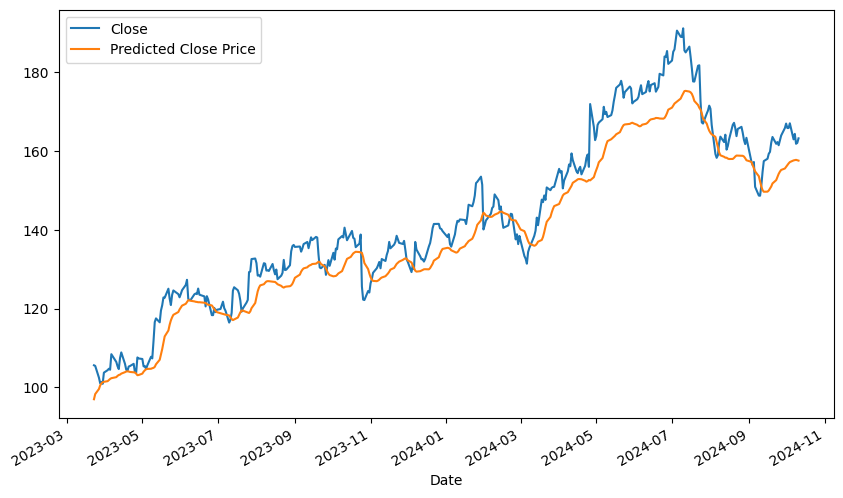

In [72]:
test_data_with_predictions[['Close','Predicted Close Price']].plot(figsize=(10,6))

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_data_with_predictions['Close'].values  # Actual 'Close' prices
y_pred = test_data_with_predictions['Predicted Close Price'].values  # Predicted 'Close' prices

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 5.535751782981525
Mean Squared Error (MSE): 43.93199685012805
Root Mean Squared Error (RMSE): 6.628121668325654


In [74]:
pre_2024_05_predictions = test_data_with_predictions.loc[:'2024-05-01']

<Axes: xlabel='Date'>

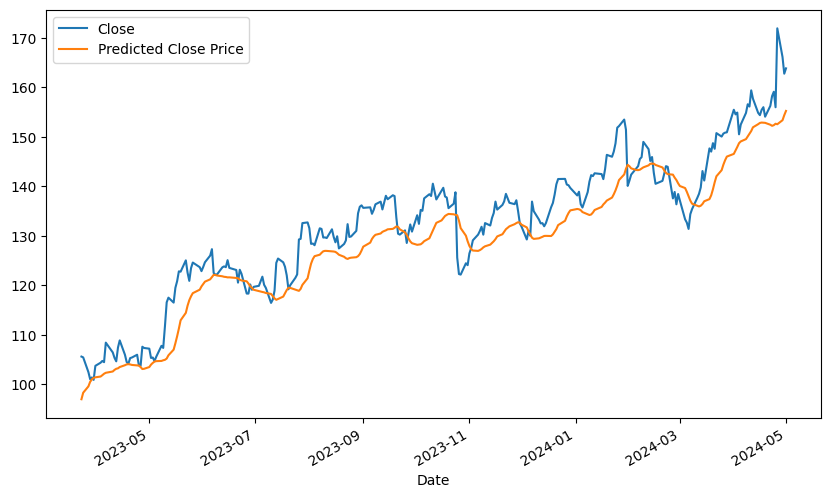

In [75]:
pre_2024_05_predictions[['Close','Predicted Close Price']].plot(figsize=(10,6))

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = pre_2024_05_predictions['Close'].values  # Actual 'Close' prices
y_pred = pre_2024_05_predictions['Predicted Close Price'].values  # Predicted 'Close' prices

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 4.622096653002749
Mean Squared Error (MSE): 31.444595636873597
Root Mean Squared Error (RMSE): 5.6075480949229135


It seems that adding the close prices of companies in the same sector actually had a slightly negative impact on the predictive accuracy of the model.

**Let's consider using technical indicators as features**

In [8]:
!pip install pandas_ta
import pandas_ta as ta

**Technical Indicators:**
*  Relative Strength Index (RSI):
RSI is a momentum oscillator that measures the speed and change of price movements, ranging from 0 to 100. Typically, an RSI above 70 indicates overbought conditions, while an RSI below 30 indicates oversold conditions. This can help the model capture overbought/oversold signals that may influence the next day's close price.
*   Moving Averages (SMA and EMA): SMA (Simple Moving Average) is a basic moving average that gives equal weight to all the values over a specific period. It helps smooth out price data and highlights longer-term trends.
EMA (Exponential Moving Average) places more weight on recent prices, making it more sensitive to recent changes. This is particularly useful for capturing momentum in a price trend.
* Moving Average Convergence Divergence (MACD): The MACD indicator is used to identify changes in the strength, direction, momentum, and duration of a trend. It is based on the difference between two EMAs (usually 12-day and 26-day) and is accompanied by a signal line (usually a 9-day EMA).
* ATR is a volatility indicator that measures the range between the high and low prices over a period. It gives an indication of the volatility of the stock, which can be important for predicting the next price movement.
* Bollinger Bands consist of a moving average (typically 20-day SMA) and two standard deviations away from it, creating an upper and lower band. They are useful for capturing volatility. When the price touches or crosses the bands, it can indicate potential reversal points, which are useful for predicting future price movements.

There is some overlap in the information described by these features, could that be a problem?




In [21]:
ta_data = data.copy()

# Calculate technical indicators and add them to the dataframe
ta_data['RSI_14'] = ta.rsi(data['Close'], length=14)
ta_data['EMA_12'] = ta.ema(data['Close'], length=12) # EMA for short term
ta_data['SMA_50'] = ta.sma(data['Close'], length=50) # SMA for long term
macd = ta.macd(ta_data['Close'])
ta_data = pd.concat([ta_data, macd], axis=1)
ta_data['ATR'] = ta.atr(ta_data['High'], ta_data['Low'], ta_data['Close'], length=14)
# Calculate Bollinger Bands with default settings (5-period SMA and 2 standard deviations)
# 5 days is not a lot but with a volatile prices it makes a difference
bbands = ta.bbands(data['Close'])
ta_data['Bollinger_upper'] = bbands['BBU_5_2.0']
ta_data['Bollinger_lower'] = bbands['BBL_5_2.0']

ta_data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,EMA_12,SMA_50,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATR,Bollinger_upper,Bollinger_lower
Date,,,,,,,,,,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.878208,67382000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,38.205002,38.459999,37.782501,38.076500,37.982449,45216000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.872719,48206000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,37.324501,37.765499,36.764000,37.049999,36.958485,63132000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.455235,47506000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.749743,36.294457


In [22]:
# drop the beginning rows with nan for technical indicators
ta_data_cleaned = ta_data.dropna()
ta_data_cleaned.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,EMA_12,SMA_50,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATR,Bollinger_upper,Bollinger_lower
Date,,,,,,,,,,,,,,,
2016-03-15,37.300999,37.650501,37.141998,37.528500,37.435802,29832000,59.003025,36.735582,36.55733,0.172698,0.171455,0.001243,0.827568,38.044876,36.020325
2016-03-16,37.452499,37.950001,37.325001,37.868000,37.774464,29306000,61.454285,36.909800,36.55525,0.250241,0.199198,0.051042,0.812734,38.194749,36.509452
2016-03-17,37.882500,38.266998,37.868000,37.924000,37.830326,44564000,61.859379,37.065831,36.55220,0.312609,0.209253,0.103356,0.782491,38.117669,37.112732
2016-03-18,38.081501,38.106998,37.591000,37.770500,37.677204,56222000,59.998052,37.174241,36.54828,0.345666,0.193848,0.151818,0.763044,38.062365,37.378835
2016-03-21,37.695499,38.167000,37.563499,38.108002,38.013874,28774000,62.658542,37.317897,36.56944,0.394549,0.194185,0.200364,0.751419,38.220880,37.458720


In [23]:
# drop Open, High, Low, Adj, Close
ta_data_cleaned = ta_data_cleaned.drop(columns=['Open', 'High', 'Low', 'Adj Close'])
ta_data_cleaned.head()

,Close,Volume,RSI_14,EMA_12,SMA_50,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATR,Bollinger_upper,Bollinger_lower
Date,,,,,,,,,,,
2016-03-15,37.528500,29832000,59.003025,36.735582,36.55733,0.172698,0.171455,0.001243,0.827568,38.044876,36.020325
2016-03-16,37.868000,29306000,61.454285,36.909800,36.55525,0.250241,0.199198,0.051042,0.812734,38.194749,36.509452
2016-03-17,37.924000,44564000,61.859379,37.065831,36.55220,0.312609,0.209253,0.103356,0.782491,38.117669,37.112732
2016-03-18,37.770500,56222000,59.998052,37.174241,36.54828,0.345666,0.193848,0.151818,0.763044,38.062365,37.378835
2016-03-21,38.108002,28774000,62.658542,37.317897,36.56944,0.394549,0.194185,0.200364,0.751419,38.220880,37.458720


We will employ selective scaling because columns like RSI are already in a bounded range.

In [26]:
from sklearn.preprocessing import MinMaxScaler

# List of columns to scale (columns that are not already in a bounded range)
columns_to_scale = ['Close', 'Volume', 'EMA_12', 'SMA_50', 'MACD_12_26_9',
                    'MACDh_12_26_9', 'MACDs_12_26_9', 'Bollinger_upper', 'Bollinger_lower']

training_size = int(len(ta_data_cleaned) * 0.8)
train_data = ta_data_cleaned[:training_size]
test_data = ta_data_cleaned[training_size:]

# Initialize MinMaxScaler and fit it on the training data only
scaler = MinMaxScaler()
train_data_scaled = train_data.copy()
train_data_scaled[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

# Step 4: Transform the testing data using the scaler fitted on the training data
test_data_scaled = test_data.copy()
test_data_scaled[columns_to_scale] = scaler.transform(test_data[columns_to_scale])




In [32]:
import numpy as np

def x_y_split(data, window):
    # Convert the data to a NumPy array
    data_values = data.values  # Input data (Close, other technical indicators) - assuming already scaled -> convert to np array
    close_values = data_values[:, 0] # Output data (just Close)

    # Create empty lists to hold the input (X) and output (y) data
    X, y = [], []

    # Loop through the dataset to create sequences of `window` length
    for i in range(len(data) - window):
        # Input sequence (X) is the data from current index to current index + window
        X.append(data_values[i:i + window])
        # Output (y) is the value right after the input sequence
        y.append(close_values[i + window])

    # Convert the lists into NumPy arrays
    X, y = np.array(X), np.array(y)

    return X, y

In [33]:
window = 50
X_train, y_train = x_y_split(train_data_scaled, window)
X_test, y_test = x_y_split(test_data_scaled, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# we would expect 11 features in total

(1678, 50, 11) (1678,) (382, 50, 11) (382,)


We are going to tweak the previous model we've been using to account for the complexity of the input now. More input units to handle all the new features, and more dropout to avoid overfitting the new features.

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()

# First LSTM layer with 100 units, handling the new input shape
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Increase dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Output layer (1 unit to predict the 'Close' price)
model.add(Dense(1))

# Compile the model with the same loss and optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          44,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,301 (489.46 KB)

 Trainable params: 125,301 (489.46 KB)

 Non-trainable params: 0 (0.00 B)

We are going to try adding early stopping to prevent overfitting.

In [35]:
from keras.callbacks import EarlyStopping

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.1298 - mean_absolute_error: 0.2872 - val_loss: 0.0268 - val_mean_absolute_error: 0.1241
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0159 - mean_absolute_error: 0.0979 - val_loss: 0.0118 - val_mean_absolute_error: 0.0852
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0076 - mean_absolute_error: 0.0663 - val_loss: 0.0078 - val_mean_absolute_error: 0.0702
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0051 - mean_absolute_error: 0.0557 - val_loss: 0.0068 - val_mean_absolute_error: 0.0634
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0061 - val_mean_absolute_error: 0.0584
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0034 - mean_absolute_error: 0.0450 - val_loss: 0.0048 - val_mean_absolute_error: 0.0531
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0028 - mean_absolute_error: 0.0415 - val_l

In [41]:
# Predict the 'Close' price (1 feature) using the test data
test_predicted = model.predict(X_test)

# Create an array of zeros with the same shape as test_predicted for the 'Volume' column
dummy_features = np.zeros((test_predicted.shape[0], 8))  # 9 features were scaled, including close

# Concatenate the predicted 'Close' price with the dummy features
test_predicted_with_dummy = np.concatenate((test_predicted, dummy_features), axis=1)

# Now apply inverse_transform using the MinMaxScaler fitted on the training data
test_inverse_predicted = scaler.inverse_transform(test_predicted_with_dummy)

# Extract only the 'Close' price (first column) after inverse transformation
test_inverse_predicted = test_inverse_predicted[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(382, 1)
(382, 9)


In [42]:
# Make a copy of the original test_data
test_data_with_predictions = test_data.copy()

# Add the predicted 'Close' prices as a new column to the copied DataFrame
# We skip the first `window` rows in both the original and predicted data
test_data_with_predictions = test_data_with_predictions.iloc[window:]
test_data_with_predictions['Predicted Close Price'] = test_inverse_predicted

# Display the new DataFrame with the original test data and the predicted prices
test_data_with_predictions.head()

,Close,Volume,RSI_14,EMA_12,SMA_50,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATR,Bollinger_upper,Bollinger_lower,Predicted Close Price
Date,,,,,,,,,,,,
2023-04-06,108.419998,48711500,68.523700,103.499163,98.0388,2.678670,0.378389,2.300281,2.834622,108.484271,101.795731,105.140467
2023-04-10,106.440002,27067400,62.591188,103.951600,98.2172,2.714847,0.331653,2.383194,2.867863,108.807799,102.556203,106.190175
2023-04-11,105.349998,26311800,59.535411,104.166738,98.3368,2.625300,0.193685,2.431615,2.809444,108.761637,102.998363,106.619542
2023-04-12,104.639999,24370300,57.564015,104.239547,98.4908,2.468586,0.029577,2.439009,2.780913,108.771991,102.956009,106.742748
2023-04-13,107.430000,24843600,62.779682,104.730386,98.6626,2.540237,0.080982,2.459255,2.785848,109.187639,103.724360,106.727876


<Axes: xlabel='Date'>

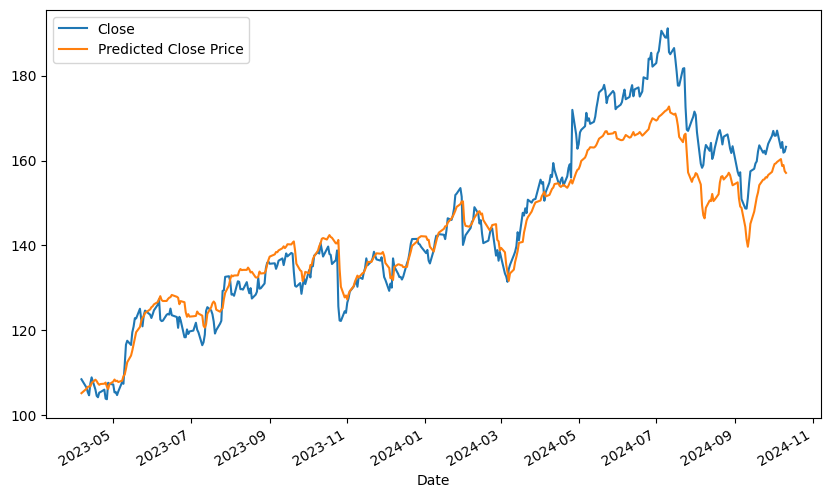

In [43]:
test_data_with_predictions[['Close','Predicted Close Price']].plot(figsize=(10,6))

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_data_with_predictions['Close'].values  # Actual 'Close' prices
y_pred = test_data_with_predictions['Predicted Close Price'].values  # Predicted 'Close' prices

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 4.963181361229705
Mean Squared Error (MSE): 43.132842284229675
Root Mean Squared Error (RMSE): 6.567559842455162


Overall it seems like the model did better until 2024-05. Which is when we see one of the most sudden spikes in the price of Google stock. This suggests that this model may be better than the previous ones, but in general, all of them struggle with adjusting to significant, sudden price movements.

In [45]:
pre_2024_05_predictions = test_data_with_predictions.loc[:'2024-05-01']

<Axes: xlabel='Date'>

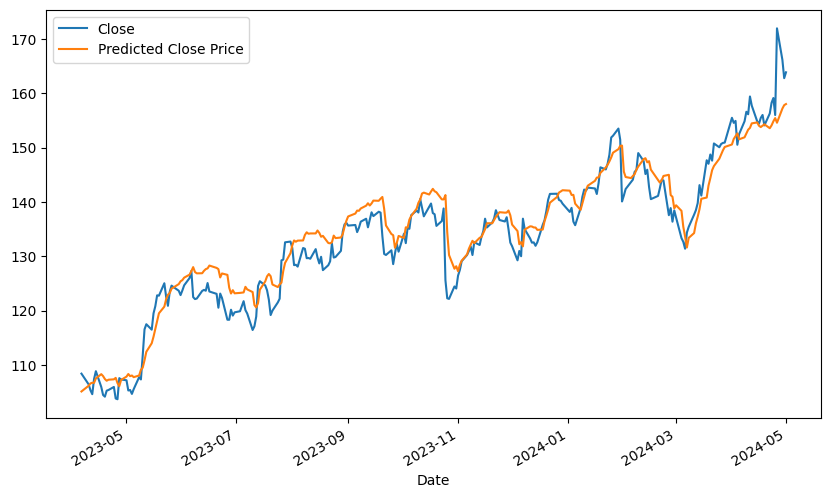

In [46]:
pre_2024_05_predictions[['Close','Predicted Close Price']].plot(figsize=(10,6))

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = pre_2024_05_predictions['Close'].values  # Actual 'Close' prices
y_pred = pre_2024_05_predictions['Predicted Close Price'].values  # Predicted 'Close' prices

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2.849683444750357
Mean Squared Error (MSE): 13.536563866457165
Root Mean Squared Error (RMSE): 3.679206961623274


Much less error pre 05/2024